In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from tqdm import tqdm

In [6]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 150

params_grid = {"color": 'lightgrey', "linestyle": 'dotted', "linewidth": 0.7 }

# Option Pricing with Binomial Tree and Monte Carlo Simulation

This notebook implements a numerical framework for pricing financial options using :

- A **binomial tree model** (Cox-Ross-Rubinstein) to compute the exact price through backward induction.
- A **Monte Carlo simulation** based on the optimal stopping strategy derived from the tree.

### Objectives:
- Build the asset price tree (binomial model).
- Calculate the value of European and American options using dynamic programming.
- Evaluate the same strategy using Monte Carlo paths.
- Visualize the optimal stopping regions.

> The binomial model is particularly useful for American-style options, where early exercise is possible.

## Asset Class

This class models the underlying financial asset (e.g., a stock) under the risk-neutral measure.

**Attributes:**
- `s0` : Initial price of the asset.
- `r` : Constant risk-free interest rate.
- `sigma` : Volatility of the asset.
- `T` : Maturity of the option (in years).
- `N` : Number of discrete time steps.
- The up factor `u` and down factor `d` based on volatility.
- The risk-neutral probability `p` :
  $
  p = \frac{1}{2} \left(1 + \frac{r - q - \frac{1}{2} \sigma^2}{\sigma} \sqrt{\Delta_t} \right)
  $

This asset object provides the structural inputs to the binomial pricing model and is reused across option types (call, put, etc.).

In [7]:
class Asset:
    def __init__(self, s0, r, sigma, div = 0, T = 1, N = 100):
        self.N = N
        self.T = T
        self.delta = T / N
        self.s0 = s0
        self.r = r
        self.sigma = sigma
        self.div = div

        self.u = np.exp(self.sigma * np.sqrt(self.delta))                                # Up factor
        self.d = 1 / self.u                                                              # Down factor
        self.p = 0.5 * (1 + ((r - div - 0.5 * sigma**2) / sigma) * np.sqrt(self.delta))  # Risk-neutral probability

    def asset_paths(self):
            """
            Computes the binomial tree of asset prices at each node and time step.

            Returns:
            --------
            list of numpy arrays:
                Each array contains asset prices at a given time step.
            """
            price_tree = []
            for n in range(self.N + 1):
                up_moves = np.arange(n + 1)
                down_moves = n - up_moves
                prices = self.s0 * (self.u ** up_moves) * (self.d ** down_moves)
                price_tree.append(prices)
            return price_tree

## Option Classes (Put / Call)

These classes implement the payoff functions and transition parameters for European/American options.

Each option stores:
- A reference to the `Asset` instance.
- The strike price `K`.

The `payoff(states)` function computes the discounted payoff at each node of the tree given the number of up moves.

- **Put** : $\max(K - S, 0)$
- **Call** : $\max(S - K, 0)$


In [8]:
class PutOption():
    def __init__(self, asset_instance, K):
        self.asset_instance = asset_instance
        self.K = K

    def payoff(self, X):
        return [np.exp(-self.asset_instance.r * i * self.asset_instance.delta) * np.maximum(0, self.K - X[i])
                    for i in range(len(X))]
    
class CallOption():
    def __init__(self, asset_instance, K):
        self.asset_instance = asset_instance
        self.K = K
        
    def payoff(self, X):
        return [np.exp(-self.asset_instance.r * i * self.asset_instance.delta) * np.maximum(0, X[i] - self.K)
                    for i in range(len(X))]

## BinomialTreeOption Class

This class ties together the asset and option definitions to:
1. Build the binomial tree of states.
2. Compute transition probabilities.
3. Evaluate the option value through backward induction or Monte Carlo.

### Main Components:
- `tree_structure` : List of possible numbers of up moves at each time step.
- `option_values` : Discounted payoffs computed at each node.
- `transition_matrices` : Probability matrices from one time step to the next.


## Backward Induction

`compute_option_price` implements dynamic programming to solve for the option price.

Steps:
1. Initialize terminal payoffs.
2. Move backwards in time, computing:
   $$
   V_n = \max(\text{payoff}_n, P_n \cdot V_{n+1})
   $$
   where $P_n$ is the transition matrix and $V_{n+1}$ the value at the next step.
3. The resulting value at time $0$ is the estimated price.

This method automatically computes the optimal early exercise strategy for American options.


## Monte Carlo Estimation

`compute_MC_option_price` simulates `sample_size` paths through the binomial tree to estimate the option value.

Steps:
1. Use the stopping rule from `compute_option_price`.
2. For each simulated path, follow transitions using $P_n$, and stop as soon as the optimal policy allows.
3. Average the discounted payoffs over all paths to compute an expected value.
4. Compute a confidence interval using the normal approximation.

This method is useful to validate the optimal policy or extend to more complex models (e.g., high-dimensional cases).


## Visualization

`_plot_continuation_values` plots:
- The **continuation region** (green): optimal to continue holding the option.
- The **stopping region** (red): optimal to exercise the option.

It displays values across the tree with colors indicating whether exercising is optimal at a given node.

Useful for:
- Interpreting early exercise behavior.
- Comparing put vs call strategies.
- Understanding the shape of the free boundary (optimal exercise frontier).


In [15]:
class BinomialTreeOption:
    def __init__(self, asset_instance, option_type):
        """
        Initializes a binomial tree pricer for American-style options.

        Parameters:
        - asset_instance : Object modeling the asset dynamics (with binomial tree attributes).
        - option_type : Payoff object defining the option contract.
        """
        self.asset_instance = asset_instance
        self.option_type = option_type

        self.tree_structure = self._compute_tree_states()
        self.asset_prices = self.asset_instance.asset_paths()
        self.option_values = option_type.payoff(self.asset_prices)
        self.transition_matrices = self._generate_transition_matrices()

    def _compute_tree_states(self):
        """
        Generates the list of reachable nodes at each time step in the binomial tree.

        Returns:
        - list of np.ndarrays: up move counts per time step.
        """
        return [np.arange(i + 1) for i in range(self.asset_instance.N + 1)]

    def _generate_transition_matrices(self):
        """
        Builds the transition probability matrices between time steps.

        Returns:
        - list of 2D numpy arrays: transition matrices of shape (i, i+1).
        """
        matrices = [np.zeros((len(self.tree_structure[i]), len(self.tree_structure[i + 1])))
                    for i in range(self.asset_instance.N)]

        for mat in matrices:
            for j in range(mat.shape[0]):
                mat[j, j + 1] = self.asset_instance.p
                mat[j, j] = 1 - self.asset_instance.p
        return matrices

    def compute_option_price(self, plot_continuation=False):
        """
        Computes the option price via backward induction on the binomial tree.

        Parameters:
        - plot_continuation : bool, whether to visualize continuation values.

        Prints:
        - Exact price of the option at time 0.
        """
        print("Pricing the option using a binomial tree (backward induction)...")

        payoffs = self.option_values
        V = [np.copy(payoffs[n]) for n in range(self.asset_instance.N + 1)]

        for n in reversed(range(self.asset_instance.N)):
            V[n] = np.maximum(payoffs[n], self.transition_matrices[n] @ V[n + 1])

        stop = [(payoffs[n] == V[n]).astype(int) for n in range(self.asset_instance.N + 1)]

        print(f"\n=== Option Pricing Results ===")
        print(f"Exact Price : {V[0][0]:.6f}\n")

        if plot_continuation:
            self._plot_continuation_values(V, payoffs, stop)

    def compute_MC_option_price(self, sample_size=10_000, confidence_level=0.95):
        """
        Computes the option price via Monte Carlo using the optimal stopping policy.

        Parameters:
        - sample_size : int, number of Monte Carlo paths.
        - confidence_level : float, for the confidence interval.

        Prints:
        - Estimated option price and confidence interval.
        """
        print("Pricing the option via Monte Carlo simulation on the binomial tree...")

        payoffs = self.option_values
        V = [np.copy(payoffs[n]) for n in range(self.asset_instance.N + 1)]
        for n in reversed(range(self.asset_instance.N)):
            V[n] = np.maximum(payoffs[n], self.transition_matrices[n] @ V[n + 1])

        stop = [(payoffs[n] == V[n]).astype(int) for n in range(self.asset_instance.N + 1)]

        payoff_opt = np.zeros(sample_size)
        path = np.zeros(self.asset_instance.N + 1, dtype=int)

        for j in tqdm(range(sample_size)):
            for n in range(1, self.asset_instance.N + 1):
                path[n] = np.random.choice(
                    np.arange(self.transition_matrices[n - 1].shape[1]),
                    p=self.transition_matrices[n - 1][path[n - 1]]
                )
                if stop[n][path[n]] == 1:
                    break
            payoff_opt[j] = payoffs[n][path[n]]

        mean_payoff = np.mean(payoff_opt)
        variance = np.var(payoff_opt, ddof=1)
        alpha = 1 - confidence_level
        quantile = stats.norm.ppf(1 - alpha / 2)
        ci_lower = mean_payoff - quantile * np.sqrt(variance / sample_size)
        ci_upper = mean_payoff + quantile * np.sqrt(variance / sample_size)

        print(f"\n=== Option Pricing Results ===")
        print(f"Estimated Price      : {mean_payoff:.6f}")
        print(f"Confidence Level     : {confidence_level*100:.1f}%")
        print(f"Confidence Interval  : [{ci_lower:.6f}, {ci_upper:.6f}]\n")

    def _plot_continuation_values(self, V, payoffs, stop):
        """
        Plots the continuation region and early exercise boundary.

        Parameters:
        - V : list of np.ndarrays, value functions at each node.
        - payoffs : list of np.ndarrays, payoff at each node.
        - stop : list of np.ndarrays, binary indicators for exercise decision.
        """
        print(f"Plotting continuation values...")
        _, ax = plt.subplots()
        ax.grid(True)

        colors = {1: 'red', 0: 'green'}
        for n in range(self.asset_instance.N + 1):
            for v, z, s in zip(V[n], payoffs[n], stop[n]):
                ax.scatter(n, z, color = colors[s], marker = 'o', s = 1)
                if n == 0:
                    ax.annotate(f'{v:.1f}', xy=(n, z), xytext=(0, 12),
                                textcoords = 'offset points', ha = 'center', va = 'center',
                                bbox=dict(boxstyle = 'round,pad=0.2', fc = colors[s], alpha = 0.3))

        frontier = [(n, payoffs[n][k]) for n in range(self.asset_instance.N + 1)
                    for k, s in enumerate(stop[n]) if s == 1]
        fx = np.array(frontier)[:, 0]
        fy = np.array(frontier)[:, 1]
        ax.plot(fx, fy, color = 'red')
        ax.set_title("Continuation Region and Exercise Boundary")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Payoff")
        plt.show()

Pricing the option using a binomial tree (backward induction)...

=== Option Pricing Results ===
Exact Price : 8.137980

Plotting continuation values...


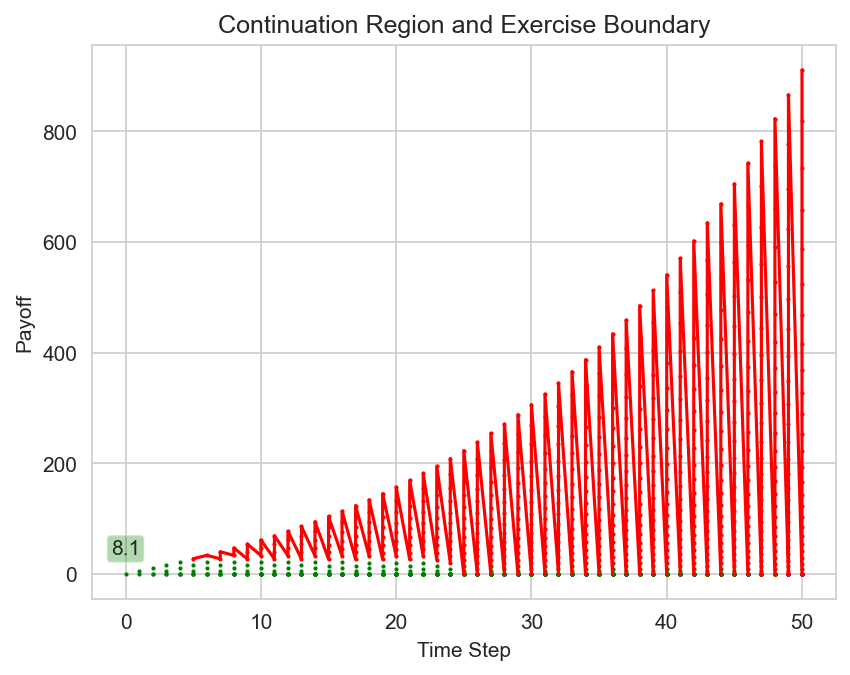

In [16]:
asset = Asset(s0 = 100, 
              r = 0.05, 
              div = 0.1,
              sigma = 0.2, 
              T = 3, 
              N = 50)

contract = CallOption(asset, K = 100)

BinomialTreeOption(asset, contract).compute_option_price(plot_continuation = True)

In [17]:
BinomialTreeOption(asset, contract).compute_MC_option_price(sample_size = 10_000,
                                                            confidence_level = 0.95)

Pricing the option via Monte Carlo simulation on the binomial tree...


100%|██████████| 10000/10000 [00:02<00:00, 4080.12it/s]


=== Option Pricing Results ===
Estimated Price      : 8.122166
Confidence Level     : 95.0%
Confidence Interval  : [7.903600, 8.340733]

